## MNIST Handwritten Digit Recognition from Images using PyTorch

This notebook explores how we can build a simple convolutional neural network in PyTorch and train it to recognize handwritten digits using the MNIST dataset.

<a href="https://pytorch.org/vision/stable/datasets.html#mnist"/>Link to the DataSet</a>

---

### Import Libraries

In [3]:
import torch
import torchvision

from torchvision.datasets import MNIST
from torchvision import transforms

from torch.utils.data.dataloader import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch.nn as nn
import torch.nn.functional as func
import torch.optim as optim

### Import Data
Download the Raw Handwritten images locally and convert them into Tensors

In [4]:
datatensor = MNIST(root='data/',train = True, download=False,transform = transforms.ToTensor())
testtensor = MNIST(root='data/',train = False, download=False,transform = transforms.ToTensor())

### Data Splitting
#### Split Data into Training and Validation Set

In [5]:
train_set, val_set = torch.utils.data.random_split(datatensor, [50000, 10000])

In [6]:
# random_seed = 1
# torch.backends.cudnn.enabled = False
# torch.manual_seed(random_seed)

#### Load Data into Batches to speed up learning

In [7]:
batch_size_train = 100
batch_size_test = 100

train_loader = DataLoader(train_set,batch_size_train) 
val_loader = DataLoader(val_set,batch_size_test)

### Build Convolutional Neural Network

#### Build a custom class with multiple layers using the nn Module
The below example makes use of 2 Convolutional Layers. The resulting output is reshaped and passed through a Linear Layer.

In [8]:
class MnistModel(nn.Module):
    def __init__(self):
        super(MnistModel, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=(2,2))
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        
        self.fc1 = nn.Linear(320, 50)
        
    def forward(self, x):
        x = func.relu(self.conv1(x))
        x = func.relu(self.pool(x))
        
        x = func.relu(self.conv2(x))
        x = func.relu(self.pool(x))
        
        x = x.view(-1, 320)
        x = func.relu(self.fc1(x))
        
        return x

#### Build the Model

In [9]:
model = MnistModel()

#### Displays the Total Trainable Parameters

In [10]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)

+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| conv1.weight |    250     |
|  conv1.bias  |     10     |
| conv2.weight |    5000    |
|  conv2.bias  |     20     |
|  fc1.weight  |   16000    |
|   fc1.bias   |     50     |
+--------------+------------+
Total Trainable Params: 21330


21330

### Gradient Descent using Stochastic Gradient Descent

In [11]:
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum = 0.5)

### Cross Entropy for Calculating Loss

In [12]:
loss = nn.CrossEntropyLoss()

### Preparation for Tracing Logs
Python Lists for recording logs at every 10 intervals

In [13]:
train_loss = list()
train_accuracy = list()
train_counter = list()

test_loss = list()
test_accuracy = list()

### Define Function for Learning
#### Function for Learning Training Data
* Step 1 - Calculate Logits
* Step 2 - Calculate Loss
* Step 3 - Zeroing the Gradients
* Step 4 - Back Propogation
* Step 5 - Trace Logs at every 10th iteration

In [14]:
def train(epoch):
    
    model.train()
    
    for batch,(images, labels) in enumerate(train_loader):
        
        logits = model(images)
        loss_obj = loss(logits, labels)
        
        optimizer.zero_grad()
        loss_obj.backward()
        
        optimizer.step()
    
        if batch % 10 == 0:
            train_loss.append(loss_obj.item())
            train_accuracy.append(labels.eq(logits.detach().argmax(dim=1)).float().mean())
            train_counter.append((batch * 100) + ((epoch-1)*len(train_loader.dataset)))
    
    train_loss_mean = torch.tensor(train_loss).mean()
    train_accuracy_mean = torch.tensor(train_accuracy).mean()
    
    print(f"Epoch {epoch}: Training Data Loss :{train_loss_mean} Accuracy: {train_accuracy_mean}\n")

#### Function to apply Learning on Validation Data
* Step 1 - Calculate Logits
* Step 2 - Calculate Loss

In [15]:
def test(epoch):
    
    model.eval()
    
    with torch.no_grad():
        for batch,(images,labels) in enumerate(val_loader):
            logits = model(images)
            
            loss_obj = loss(logits, labels)
            
            if batch % 10 == 0:
                test_loss.append(loss_obj.item())
                test_accuracy.append(labels.eq(logits.detach().argmax(dim=1)).float().mean())
            
    test_loss_mean = torch.tensor(test_loss).mean()
    test_accuracy_mean = torch.tensor(test_accuracy).mean()
    
    print(f"Epoch {epoch}: Validation Data Loss :{test_loss_mean} Accuracy: {test_accuracy_mean}\n")

### Train the Model

In [16]:
epochs = 5

In [17]:
for epoch in range(1, epochs+1):
    train(epoch)
    test(epoch)

Epoch 1: Training Data Loss :0.7806190252304077 Accuracy: 0.8101999759674072

Epoch 1: Validation Data Loss :0.5411665439605713 Accuracy: 0.8679999113082886

Epoch 2: Training Data Loss :0.6254215836524963 Accuracy: 0.8464999198913574

Epoch 2: Validation Data Loss :0.5239796042442322 Accuracy: 0.8725000619888306

Epoch 3: Training Data Loss :0.5661258697509766 Accuracy: 0.8599998950958252

Epoch 3: Validation Data Loss :0.5142133235931396 Accuracy: 0.8740001320838928

Epoch 4: Training Data Loss :0.5333955883979797 Accuracy: 0.8676999807357788

Epoch 4: Validation Data Loss :0.5079742074012756 Accuracy: 0.8742499351501465

Epoch 5: Training Data Loss :0.5120067000389099 Accuracy: 0.8728799819946289

Epoch 5: Validation Data Loss :0.5036076307296753 Accuracy: 0.8745999932289124



### Plot the Traced Logs for Loss and Accuracy

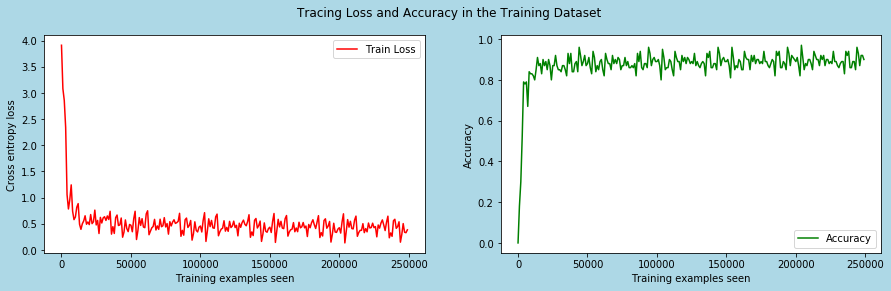

In [18]:
plt.figure(figsize=(15,4),facecolor='lightblue')

plt.suptitle("Tracing Loss and Accuracy in the Training Dataset")

ax1 = plt.subplot(1,2,1)
ax1.plot(train_counter, train_loss, color='red')
ax1.legend(['Train Loss'], loc='upper right')
ax1.set_xlabel('Training examples seen')
ax1.set_ylabel('Cross entropy loss')

ax2 = plt.subplot(1,2,2)
ax2.plot(train_counter, train_accuracy, color='green')
ax2.legend(['Accuracy'], loc='best')
ax2.set_xlabel('Training examples seen')
ax2.set_ylabel('Accuracy')

plt.savefig("tracing.png")

### Apply Model on Test Data
Plug the model by removing gradients from the Tensors

In [19]:
test_batch_size = 100
test_loader = DataLoader(testtensor,test_batch_size) 

In [20]:
for images, labels in test_loader:
    with torch.no_grad():
        output = model(images)
        break

#### Plot the Predictions

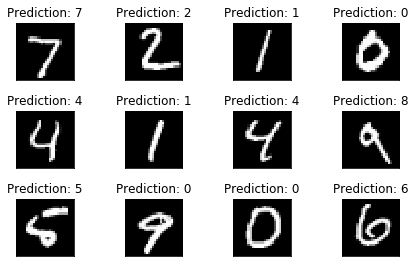

In [21]:
fig = plt.figure()
for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(images[i][0], cmap='gray', interpolation='none')
  plt.title(f"Prediction: {output.data.max(1)[1][i].item()}")
  
  plt.xticks([])
  plt.yticks([])
plt.savefig("predictions.png")

### Save Model into Pickle File

In [22]:
import pickle

# wb - refers to writing as binary
with open("cnn_mnist.pkl","wb") as file:
    pickle.dump(model,file)

In [23]:
with open("cnn_mnist.pkl","rb") as file:
    cnn_model_mnist = pickle.load(file)

---
### Experiment with Random Handwritten Images
<a href="https://github.com/penroselearning/curriculum/raw/master/professional/handwritten_digits.zip">Link to Download Images</a>

In [24]:
import glob
from PIL import Image,ImageOps

In [28]:
def predict_image(img,sno,model):
    
    img = glob.glob(img)
  
    img = Image.open(image)
    img = img.resize((28, 28))
    img = ImageOps.grayscale(img)

    transform = transforms.ToTensor()
    
    transform = transforms.Compose([
     transforms.ToTensor()])
    
    new_image = transform(img)
    
    new_image = new_image.expand(100,1,28,28)
    
    with torch.no_grad():
        output = model(new_image)
        
    
    plt.subplot(4,3,sno+1)
    plt.tight_layout()
    plt.imshow(new_image[0][0], cmap='gray', interpolation='none')
    plt.title(f"Prediction: {output.data.max(1)[1][0].item()}")
  
    plt.xticks([])
    plt.yticks([])

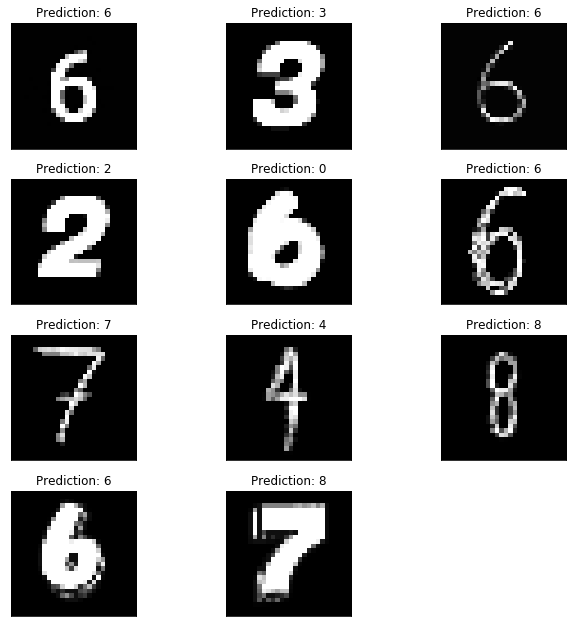

In [29]:
images = glob.glob("data/handwritten/*.png")
plt.figure(figsize=(9,9))

for sno,image in enumerate(images):
    predict_image(image,sno,cnn_model_mnist)
    
plt.savefig("random_prediction.png")

### Summary
With a 97% Accuracy on the MNIST Model, we were able to get an 81% accuracy on random images of handwritten numbers